
##0. GOAL
진우는 부쩍 헬스에 관심이 많이 생겼다고 합니다.
주변 헬스인들에게 이 사실을 알리니, 프로틴 보충제 사이트를 추천해주더군요.

며칠 전 텍스트 전처리를 배운 진우는 해당 사이트에서 보충제 리뷰를 크롤링해와 워드클라우드를 그려보기로 결심합니다.

파이프라인은 다음과 같습니다.

 1. 정규표현식으로 한글만 추린다
 2. 띄어쓰기를 교정한다(PyKospacing)
 3. 형태소로 토큰화한다(okt)
 4. 불용어를 제거한다
 5. 원하는 단어를 Konlpy 사전에 추가한다
 6. 워드클라우드를 그린다


##1. Import data

In [ ]:
# konlpy 패키지 설치
!pip install konlpy

# PyKoSpacing 패키지 설치
# 한국어 문장에서 공백을 교정해주는 라이브러리
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 29.1 MB/s eta 0:00:00
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-22k495m3
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-22k495m3
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit b32a889cbd10b006d2f4aba118f0cd5b677e2979
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 39.3 MB/s et

In [ ]:
import pandas as pd
import numpy as np
import re
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 불러오기
df = pd.read_csv("https://raw.githubusercontent.com/KU-BIG/KUBIG_2024_SPRING/main/BASIC%20STUDY/NLP/WEEK1/protein.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   title       1000 non-null   object
 2   content     1000 non-null   object
 3   text        1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [ ]:
df.head()

,Unnamed: 0,title,content,text
0,0,처음 사먹어 보는데 맛있네요,맛이 좋아서 꾸준히 먹고 있습니다.^^,처음 사먹어 보는데 맛있네요맛이 좋아서 꾸준히 먹고 있습니다.^^
1,1,말해 뭐합니까 ㅋㅋㅋ 역시,가성비 갑 제품 + 맛도 다양해서 ㅋㅋㅋ 항상 구매하고 있습니다요! \n\n ...,말해 뭐합니까 ㅋㅋㅋ 역시가성비 갑 제품 + 맛도 다양해서 ㅋㅋㅋ 항상 구매하고 있...
2,2,좋넹요,맛있습니다. 저번에 말차라떼도 먹어봤는데 그것보다 더 나은거 같네요,좋넹요맛있습니다. 저번에 말차라떼도 먹어봤는데 그것보다 더 나은거 같네요
3,3,매우 만족합니다,5키로는 정말 엄청크네요.\n 평점이 좋아서 스트로베리크림으로 주문했는데 좋습...,매우 만족합니다5키로는 정말 엄청크네요.\n 평점이 좋아서 스트로베리크림으로 ...
4,4,마싯어요,약간 달긴 하지만 물에 잘 녹고 가루날림이 거의없어 좋아요,마싯어요약간 달긴 하지만 물에 잘 녹고 가루날림이 거의없어 좋아요


In [ ]:
df.tail()

,Unnamed: 0,title,content,text
995,995,시나몬 데니쉬,단호박이랑 같이 먹으면 충격적으로 맛있습니다....,시나몬 데니쉬단호박이랑 같이 먹으면 충격적으로 맛있습니다....
996,996,말차 최고네요.,"제가 지금까지 먹으본 보충제 중에 제일 질리지 않고, 보충제 안먹는 느낌? 그만큼 ...","말차 최고네요.제가 지금까지 먹으본 보충제 중에 제일 질리지 않고, 보충제 안먹는 ..."
997,997,굿 프로틴!,항상 먹는 프로틴입니다.\n\n 설사도 없고 아주 좋아요~\n 건강한 운...,굿 프로틴!항상 먹는 프로틴입니다.\n\n 설사도 없고 아주 좋아요~\n ...
998,998,잘 구매한 거 같다,간편하고 좋다 가격도 할인해서 잘 산 거 같다 막입이라서 맛도 괜찮은 거 같다,잘 구매한 거 같다간편하고 좋다 가격도 할인해서 잘 산 거 같다 막입이라서 맛도 괜...
999,999,내츄럴 초코와 내츄럴 스트로베리를 주문했습니다.,둘다 먹는데 큰 부담은 없습니다만 딸기맛이 좀 거품이 많이나긴하네요\n 맛자체...,내츄럴 초코와 내츄럴 스트로베리를 주문했습니다.둘다 먹는데 큰 부담은 없습니다만 딸...


# 2. Data Preprocessing

### 정규표현식을 활용해 한글 단어만 남기기


In [ ]:
def extract_hangul(text):
    # 입력된 문자열에서 한글만 남기고 나머지는 공백으로 대체하는 함수
    hangul = re.sub('[^가-힣]', ' ', text)
    return hangul


In [ ]:
example = extract_hangul(df['text'][0])  # df 데이터프레임의 'text' 열에서 첫 번째 행을 한글만 남도록 전처리
print("전처리 이전: ", df['text'][0])   # 전처리 이전의 원본 텍스트
print("전처리 이후: ", example)         # 전처리 이후의 한글만 남은 텍스트

# 전처리 이후 특수 기호 ^^가 사라졌음을 확인할 수 있다.

전처리 이전:  처음 사먹어 보는데 맛있네요맛이 좋아서 꾸준히 먹고 있습니다.^^
전처리 이후:  처음 사먹어 보는데 맛있네요맛이 좋아서 꾸준히 먹고 있습니다   


In [ ]:
example2 = extract_hangul(df['text'][1])  # df 데이터프레임의 'text' 열에서 첫 번째 행을 한글만 남도록 전처리
print("전처리 이전: ", df['text'][1])   # 전처리 이전의 원본 텍스트
print("전처리 이후: ", example2)         # 전처리 이후의 한글만 남은 텍스트

# 전처리 이후 ㅋㅋㅋ,+ 기호, 느낌표가 사라졌음을 확인할 수 있다.

전처리 이전:  말해 뭐합니까 ㅋㅋㅋ 역시가성비 갑 제품 + 맛도 다양해서 ㅋㅋㅋ 항상 구매하고 있습니다요! 

    스트로베리 크림치즈가 가장 맛있었네요!
전처리 이후:  말해 뭐합니까     역시가성비 갑 제품   맛도 다양해서     항상 구매하고 있습니다요        스트로베리 크림치즈가 가장 맛있었네요 


### 띄어쓰기 교정

- `PyKoSpacing`은 띄어쓰기가 되지 않은 문장을 띄어쓰기가 된 문장으로 교정해주는 패키지이다. 앞서 한글 외 다른 문자를 공백으로 치환했는데, 중첩된 공백들도 이 띄어쓰기 교정으로 하나의 공백으로 바꿔줄 수 있다.

In [ ]:
from pykospacing import Spacing
spacing = Spacing()

In [ ]:
# text에 대해서 띄어쓰기 교정 진행
def spacing_text(text):
  spaced_text = spacing(text)
  return spaced_text

In [ ]:
spaced = spacing_text(example)
print("전처리 이전: ",example)
print("전처리 이후: ",spaced)


전처리 이전:  처음 사먹어 보는데 맛있네요맛이 좋아서 꾸준히 먹고 있습니다   
전처리 이후:  처음 사 먹어 보는데 맛있네 요 맛이 좋아서 꾸준히 먹고 있습니다


In [ ]:
spaced2= spacing_text(example2)
print("전처리 이전: ",example2)
print("전처리 이후: ",spaced2)

# 전처리 히우 불필요한 공백이 상당 부분 사라진 것을 확인할 수 있다

전처리 이전:  말해 뭐합니까     역시가성비 갑 제품   맛도 다양해서     항상 구매하고 있습니다요        스트로베리 크림치즈가 가장 맛있었네요 
전처리 이후:  말해 뭐 합니까 역시 가성비 갑 제품 맛도 다양해서 항상 구매하고 있습니다 요 스트로베리 크림치즈가 가장 맛있었네요


## 형태소 분석

- 한국어에서 토큰화를 해주는 대표적인 도구는 `konlpy`입니다. 가장 대표적인 형태소 분석기는 `Okt` 모델입니다.

In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
# okt.morphs를 활용하여 텍스트를 형태소 단위로 분리하고, 동사의 경우 기본형으로 변환(stem=True)하여 형태소 리스트를 반환
def extract_morphs(text):
    morphs_ = okt.morphs(text, stem=True)
    return morphs_


In [ ]:
morphs_ = extract_morphs(spaced)  # spaced 변수의 텍스트에 대해 형태소 분석을 수행하여 형태소 리스트를 생성
print("전처리 이전: ", spaced)    # 형태소 분석 전의 텍스트 출력
print("전처리 이후: ", morphs_)   # 형태소 분석 후의 형태소 리스트 출력


전처리 이전:  처음 사 먹어 보는데 맛있네 요 맛이 좋아서 꾸준히 먹고 있습니다
전처리 이후:  ['처음', '사', '먹다', '보다', '맛있다', '요', '맛', '이', '좋다', '꾸준하다', '먹다', '있다']


In [ ]:
morphs_2 = extract_morphs(spaced2)  # spaced 변수의 텍스트에 대해 형태소 분석을 수행하여 형태소 리스트를 생성
print("전처리 이전: ", spaced2)    # 형태소 분석 전의 텍스트 출력
print("전처리 이후: ", morphs_)   # 형태소 분석 후의 형태소 리스트 출력


전처리 이전:  말해 뭐 합니까 역시 가성비 갑 제품 맛도 다양해서 항상 구매하고 있습니다 요 스트로베리 크림치즈가 가장 맛있었네요
전처리 이후:  ['말', '하다', '뭐', '합', '니까', '역시', '가성', '비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '있다', '요', '스트로베리', '크림', '치즈', '가', '가장', '맛있다']


## 불용어 제거

- 분석에 있어 큰 의미가 없는 '불용어(stopword)'를 지정해줘야 합니다. '하다', '도', '는', '이다' 등 의미가 없는 어미나 조사같은 것을 지워주기로 합니다.

- 불용어 참고 사이트: https://www.ranks.nl/stopwords/korean

- 위 불용어 자료에서 몇 개의 단어를 추가해서 저장해두었습니다.

In [ ]:
with open('/content/drive/MyDrive/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

def remove_stopwords(text):
  remove_stop = [x for x in text if x not in stopwords_list]
  return remove_stop

In [ ]:
remove_stop = remove_stopwords(morphs_)
print("전처리 이전: ",morphs_)
print("전처리 이후: ",remove_stop)

전처리 이전:  ['처음', '사', '먹다', '보다', '맛있다', '요', '맛', '이', '좋다', '꾸준하다', '먹다', '있다']
전처리 이후:  ['처음', '먹다', '보다', '맛있다', '요', '맛', '좋다', '꾸준하다', '먹다']


In [ ]:
remove_stop2 = remove_stopwords(morphs_2)
print("전처리 이전: ",morphs_2)
print("전처리 이후: ",remove_stop)

전처리 이전:  ['말', '하다', '뭐', '합', '니까', '역시', '가성', '비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '있다', '요', '스트로베리', '크림', '치즈', '가', '가장', '맛있다']
전처리 이후:  ['처음', '먹다', '보다', '맛있다', '요', '맛', '좋다', '꾸준하다', '먹다']


In [ ]:
# 불용어로만 걸러내기엔 한계가 있고 아예 한 글자 단어들을 전부 없애주는 것이 낫겠다.'맛', '향', '짱'과 같은 핵심적인 단어들은 남겨두었다.

def remove_one(text):
  except_list = ['맛','향','짱']
  remove_one_ = [x for x in text if len(x)>1 or x in except_list]
  return remove_one_

In [ ]:
remove_one_ = remove_one(remove_stop)
print("전처리 이전: ",remove_stop)
print("전처리 이후: ",remove_one_)

전처리 이전:  ['처음', '먹다', '보다', '맛있다', '요', '맛', '좋다', '꾸준하다', '먹다']
전처리 이후:  ['처음', '먹다', '보다', '맛있다', '맛', '좋다', '꾸준하다', '먹다']


In [ ]:
remove_one_2 = remove_one(remove_stop2)
print("전처리 이전: ",remove_stop2)
print("전처리 이후: ",remove_one_2)

전처리 이전:  ['말', '뭐', '합', '니까', '역시', '가성', '비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '요', '스트로베리', '크림', '치즈', '가장', '맛있다']
전처리 이후:  ['니까', '역시', '가성', '제품', '맛', '다양하다', '항상', '구매', '하고', '스트로베리', '크림', '치즈', '가장', '맛있다']


## 단어를 사전에 추가

그런데 몇 단어들을 찾아보니 `가성비`는 `가`, `성비`가 나뉘고 `프로틴`은 `프로`, `틴`이 나뉘는 안타까운 상황이 발생했습니다.

이런 경우, konlpy 사전에 직접 단어를 등재시키는 방법이 있습니다.

아래처럼 `os` 모듈을 사용하여 코랩 패키지에 저장된 konlpy 폴더에 손을 대는 방식입니다.

우선 `chdir`로 경로를 이동해주고 `makedirs`로 임시폴더를 만들어준 후. 이 임시폴더에서 단어 사전을 수정한 뒤 원본 폴더에 저장해줍니다.

** FileNotFoundError가 발생하는 경우 아래 directory에서 python 버전이 잘못된 경우일 수 있습니다.

In [ ]:
import os

os.chdir('/usr/local/lib/python3.10/dist-packages/konlpy/java')
os.getcwd()
os.makedirs('./aaaa')

In [ ]:
os.chdir('/usr/local/lib/python3.10/dist-packages/konlpy/java/aaaa') #임시 폴더로 이동
os.getcwd()

'/usr/local/lib/python3.10/dist-packages/konlpy/java/aaaa'

In [ ]:
!jar xvf ../open-korean-text-2.1.0.jar

  created: META-INF/
 inflated: META-INF/MANIFEST.MF
  created: org/
  created: org/openkoreantext/
  created: org/openkoreantext/processor/
  created: org/openkoreantext/processor/normalizer/
  created: org/openkoreantext/processor/phrase_extractor/
  created: org/openkoreantext/processor/qa/
  created: org/openkoreantext/processor/stemmer/
  created: org/openkoreantext/processor/tokenizer/
  created: org/openkoreantext/processor/tools/
  created: org/openkoreantext/processor/util/
  created: org/openkoreantext/processor/util/adjective/
  created: org/openkoreantext/processor/util/adverb/
  created: org/openkoreantext/processor/util/auxiliary/
  created: org/openkoreantext/processor/util/freq/
  created: org/openkoreantext/processor/util/josa/
  created: org/openkoreantext/processor/util/noun/
  created: org/openkoreantext/processor/util/substantives/
  created: org/openkoreantext/processor/util/typos/
  created: org/openkoreantext/processor/util/verb/
 inflated: org/openkoreantext/pr

In [ ]:
with open(f"/usr/local/lib/python3.10/dist-packages/konlpy/java/aaaa/org/openkoreantext/processor/util/noun/names.txt") as f:
    data = f.read()

In [ ]:
data

'가몽\n가온\n갓세븐\n강새이\n게임닉가\n관우\n귀여미\n규\n김유이\n김준면\n까까런\n노컷\n누너예\n니노\n다마고치\n다이무스\n대학생\n데이브\n도요토미\n동운\n동이\n두주니\n디시인사이드\n디오\n라몹\n라스\n라옵\n멍구\n메이든\n명덕\n명량\n문민정부\n미네\n방엘리\n병헌\n붓다\n비정상회담\n빼빼로\n삼풍\n샤인온미\n성식\n성열\n세라문\n세라복\n세종대왕\n손권\n손책\n쇼미더머니\n쇼챔\n순규\n스라소니\n신동아\n신쓰패밀리\n신아라\n아베\n안상홍\n안홍준\n여누\n여랑\n여포\n연합\n오꾸닭\n요섭\n웃찾사\n원식\n유병언\n유비\n유이\n윤기형\n이나단\n이명박\n이완용\n임창용\n자괴\n자니윤\n자대련\n자유\n재중이\n전교조\n정윤회\n제갈량\n조자룡\n조조\n준면\n지오디\n지존파\n진영오\n차작가\n차트\n창섭\n챠트\n첸\n코르사주\n하무열\n하용파쿠\n혁재\n현이\n현태\n혜미\n'

In [ ]:
# 프로틴, 가성비, 밀크티 단어 추가
data += '프로틴\n가성비\n밀크티\n'

with open("/usr/local/lib/python3.10/dist-packages/konlpy/java/aaaa/org/openkoreantext/processor/util/noun/names.txt", 'w') as f:
    f.write(data)

In [ ]:
!jar cvf ../open-korean-text-2.1.0.jar *

added manifest
ignoring entry META-INF/
adding: META-INF/maven/(in = 0) (out= 0)(stored 0%)
adding: META-INF/maven/org.openkoreantext/(in = 0) (out= 0)(stored 0%)
adding: META-INF/maven/org.openkoreantext/open-korean-text/(in = 0) (out= 0)(stored 0%)
adding: META-INF/maven/org.openkoreantext/open-korean-text/pom.properties(in = 119) (out= 110)(deflated 7%)
adding: META-INF/maven/org.openkoreantext/open-korean-text/pom.xml(in = 9127) (out= 2208)(deflated 75%)
ignoring entry META-INF/MANIFEST.MF
adding: org/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/processor/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/processor/phrase_extractor/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/processor/phrase_extractor/KoreanPhraseExtractor.class(in = 6005) (out= 3967)(deflated 33%)
adding: org/openkoreantext/processor/phrase_extractor/KoreanPhraseExtractor$KoreanPhrase$.class(in = 3358) (out= 1148)(deflated 65%)
add

In [ ]:
print(okt.nouns("가성비"))
print(okt.nouns("프로틴"))

['가성', '비']
['프로', '틴']


In [ ]:
# 전 과정 요약
from konlpy.tag import Okt
okt = Okt()

from pykospacing import Spacing
spacing = Spacing()

except_list = ['맛','향','짱']

with open('/content/drive/MyDrive/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

def review_to_words(raw_review):
  text = re.sub('[^가-힣]', ' ', raw_review)
  text = spacing(text)
  text = okt.morphs(text, stem=True)
  text = [x for x in text if x not in stopwords_list]
  text = [x for x in text if len(x)>1 or x in except_list]
  text = " ".join(text)
  return text

# 3. Wordcloud

In [ ]:
# 이제 `words_list`를 만들어 전처리한 단어들을 하나의 리스트에 모아줍니다. 띄어쓰기 교정 과정에서 약간 지연됩니다.
# 데이터프레임의 각 텍스트 데이터를 review_to_words 함수로 전처리하여 단어 리스트를 생성
import tqdm
df_len = df.shape[0]
words_list = []
for i in range(df_len):
  words_list.append(review_to_words(df['text'][i]))


In [ ]:
# wordcloud 모듈을 import하고 wordcloud 생성하기
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

def displayWordCloud(data=None, backgroundcolor='white', width=None, height=None):
    wordcloud = WordCloud(
        font_path='/content/drive/MyDrive/MALGUN.TTF',
        background_color=backgroundcolor,
        width=width,
        height=height
    ).generate(data)

    plt.figure(figsize=(15, 10))  # 그래프의 크기 설정
    plt.imshow(wordcloud)  # 워드 클라우드 이미지를 그래프에 표시
    plt.axis("off")  # 축을 표시하지 않음
    plt.show()


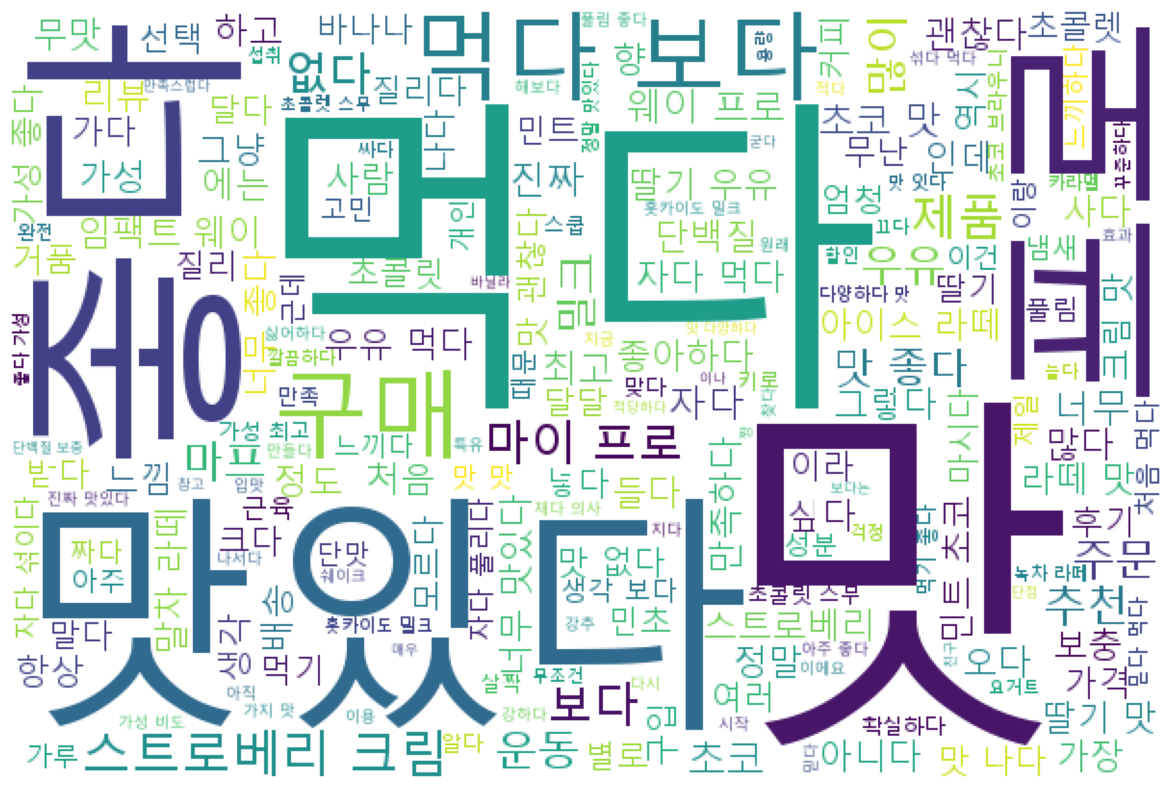

In [ ]:
displayWordCloud(data = ' '.join(words_list), width=600, height=400)